# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [3]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [6]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [7]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = nn_model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    correct_samples = 0
    total_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
        prediction = model(x)  
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]
        
    return float(correct_samples) / total_samples

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.822121, Train accuracy: 0.414633, Val accuracy: 0.554755
Average loss: 1.458488, Train accuracy: 0.584940, Val accuracy: 0.619459
Average loss: 1.381587, Train accuracy: 0.619083, Val accuracy: 0.615329


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [12]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100 instead of 1
nn_model = nn.Sequential(
                Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 2.316097, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316087, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316088, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316085, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316091, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316092, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316093, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316087, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316097, Train accuracy: 0.104511, Val accuracy: 0.104511
Average loss: 2.316093, Train accuracy: 0.104511, Val accuracy: 0.104511


Добавьте слой с Batch Normalization

In [14]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before the non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
                Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 2.178186, Train accuracy: 0.249582, Val accuracy: 0.343856
Average loss: 1.960228, Train accuracy: 0.372317, Val accuracy: 0.415930
Average loss: 1.809502, Train accuracy: 0.431594, Val accuracy: 0.469474
Average loss: 1.689713, Train accuracy: 0.481196, Val accuracy: 0.523752
Average loss: 1.583820, Train accuracy: 0.525987, Val accuracy: 0.569225
Average loss: 1.487786, Train accuracy: 0.569003, Val accuracy: 0.606337
Average loss: 1.400748, Train accuracy: 0.603095, Val accuracy: 0.640754
Average loss: 1.323802, Train accuracy: 0.629594, Val accuracy: 0.638638
Average loss: 1.253306, Train accuracy: 0.652595, Val accuracy: 0.681074
Average loss: 1.191350, Train accuracy: 0.669573, Val accuracy: 0.678412


Добавьте уменьшение скорости обучения по ходу тренировки.

In [38]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model2(model, train_loader, val_loader, loss, scheduler, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()

        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = nn_model(x)    
            loss_value = loss(prediction, y)
            
        
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [40]:
# Learing rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
                Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma = 0.5)

loss_history, train_history, val_history = train_model2(nn_model, train_loader, val_loader, loss, scheduler, optimizer, 10)

Average loss: 2.207245, Train accuracy: 0.232962, Val accuracy: 0.339795
Average loss: 2.010750, Train accuracy: 0.369314, Val accuracy: 0.419462
Average loss: 1.855335, Train accuracy: 0.436457, Val accuracy: 0.468331
Average loss: 1.717591, Train accuracy: 0.490342, Val accuracy: 0.524332
Average loss: 1.595615, Train accuracy: 0.534194, Val accuracy: 0.574361
Average loss: 1.492675, Train accuracy: 0.571460, Val accuracy: 0.605518
Average loss: 1.400996, Train accuracy: 0.606576, Val accuracy: 0.646930
Average loss: 1.319313, Train accuracy: 0.636266, Val accuracy: 0.664011
Average loss: 1.244039, Train accuracy: 0.661332, Val accuracy: 0.671177
Average loss: 1.179271, Train accuracy: 0.680698, Val accuracy: 0.712197


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [65]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of int of model predictions
    grount_truth: np array of int of actual labels of the dataset
    """
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices), 
                                           sampler=SubsetSampler(indices))

    predictions = []
    ground_truth = []
    model.eval() # Evaluation mode
    for i_step, (x, y) in enumerate(train_loader):
        prediction = nn_model(x)    
        _, indices = torch.max(prediction, 1)
        ground_truth.extend(y)
        predictions.extend(indices)
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
        
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

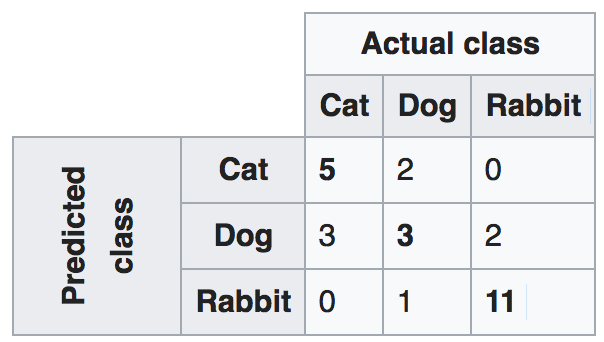

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [99]:
from sklearn.metrics import confusion_matrix as confusion_matrix2

In [100]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.xlabel("predicted")
    plt.ylabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    return confusion_matrix2(ground_truth, predictions)

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

ValueError: unknown is not supported

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [75]:
data_train_images = dset.SVHN('./data/', split='train')
data_train = dset.SVHN('./data/', split='train', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
data_size = data_train_images.data.shape[0]
indices = list(range(data_size))

predictions, gt = evaluate_model(nn_model, data_train, indices)


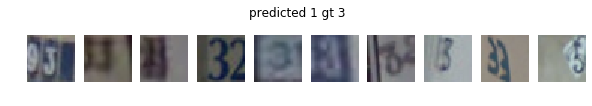

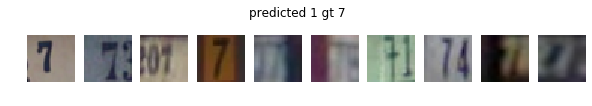

In [76]:

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    x = np.arange(0, len(predictions))
    tr =(np.equal(predicted_class, predictions)) &  (np.equal(groud_truth, gt_class))
    indices =x [tr]
    visualize_images(indices, data, 'predicted ' + str(predicted_class) + " gt " + str(gt_class))


visualize_predicted_actual(1, 3, predictions, gt, np.array(indices), data_train_images)

visualize_predicted_actual(1, 7, predictions, gt, np.array(indices), data_train_images)
#visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cuda:0


In [89]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model3(model, train_loader, val_loader, loss, scheduler, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        scheduler.step()

        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = nn_model(x.to(device))    
            loss_value = loss(prediction, y.to(device))
            
        
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y.to(device))
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy2(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def compute_accuracy2(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: torch doesn't have a dedicated argmax function,
    #       but you can use torch.max instead (see the documentation).
    correct_samples = 0
    total_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
        prediction = model(x.to(device))  
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y.to(device))
        total_samples += y.shape[0]
        
    return float(correct_samples) / total_samples


In [90]:
nn_model = nn.Sequential(
                Flattener(),
            nn.Linear(3*32*32, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
             nn.Linear(1000, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
       )
nn_model.type(torch.FloatTensor)
nn_model.to(device)
optimizer = optim.Adam(nn_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma = 0.5)

loss_history, train_history, val_history = train_model3(nn_model, train_loader, val_loader, loss, scheduler, optimizer, 20)

Average loss: 1.459475, Train accuracy: 0.513702, Val accuracy: 0.664488
Average loss: 1.048580, Train accuracy: 0.667833, Val accuracy: 0.715592
Average loss: 0.840306, Train accuracy: 0.737279, Val accuracy: 0.774426
Average loss: 0.777304, Train accuracy: 0.754718, Val accuracy: 0.803740
Average loss: 0.682850, Train accuracy: 0.787001, Val accuracy: 0.810412
Average loss: 0.652085, Train accuracy: 0.795874, Val accuracy: 0.826366
Average loss: 0.596165, Train accuracy: 0.814507, Val accuracy: 0.842525
Average loss: 0.581842, Train accuracy: 0.818739, Val accuracy: 0.845101
Average loss: 0.548821, Train accuracy: 0.829386, Val accuracy: 0.858820
Average loss: 0.538389, Train accuracy: 0.832372, Val accuracy: 0.860833
Average loss: 0.519011, Train accuracy: 0.839419, Val accuracy: 0.867539
Average loss: 0.511622, Train accuracy: 0.841706, Val accuracy: 0.869979
Average loss: 0.496431, Train accuracy: 0.845920, Val accuracy: 0.872368
Average loss: 0.496016, Train accuracy: 0.846586, V

In [93]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy2(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8799


In [95]:
def evaluate_model2(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of int of model predictions
    grount_truth: np array of int of actual labels of the dataset
    """
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices), 
                                           sampler=SubsetSampler(indices))

    predictions = []
    ground_truth = []
    model.eval() # Evaluation mode
    for i_step, (x, y) in enumerate(train_loader):
        prediction = nn_model(x.to(device))    
        _, indices = torch.max(prediction, 1)
        ground_truth.extend(y.to(device))
        predictions.extend(indices)
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
        
    return predictions, ground_truth


In [97]:
predictions, gt = evaluate_model2(nn_model, data_train, val_indices)


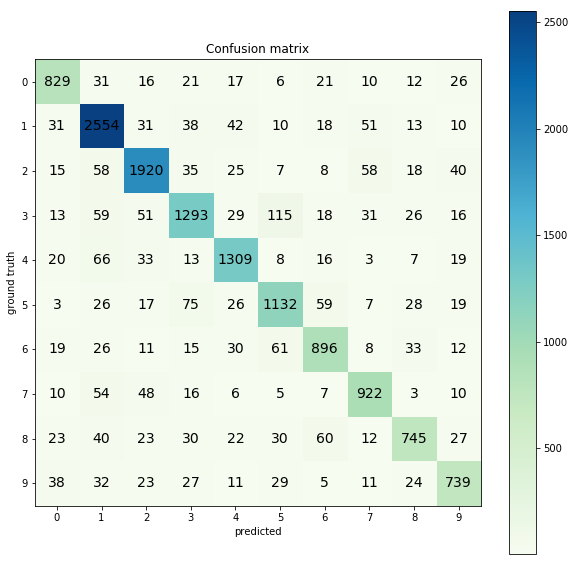

In [106]:
confusion_matrix = build_confusion_matrix(list(map(lambda x: x.cpu().numpy(),predictions)), list(map(lambda x: x.cpu().numpy(),gt)))
visualize_confusion_matrix(confusion_matrix)

In [111]:
predictions, gt = evaluate_model2(nn_model, data_train, indices)

pr = list(map(lambda x: x.cpu().numpy(),predictions))
g =         list(map(lambda x: x.cpu().numpy(),gt))

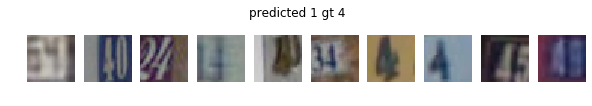

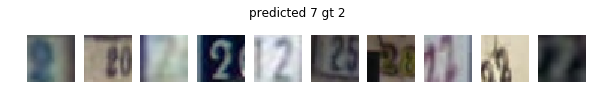

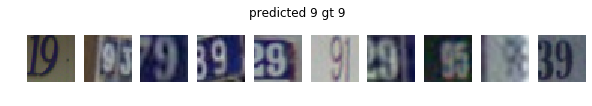

In [115]:
visualize_predicted_actual(1, 4, pr, g, np.array(indices), data_train_images)
visualize_predicted_actual(7, 2, pr, g, np.array(indices), data_train_images)
visualize_predicted_actual(9, 9, pr, g, np.array(indices), data_train_images)
